<a href="https://colab.research.google.com/github/wgova/time_series_trade/blob/master/notebooks/3.%20clustering_tsfresh_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Required packages

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

try:
  !git clone https://github.com/wgova/automations
except:
  pass
else:
  os.chdir('automations')
  !git fetch origin && git pull
  os.chdir('../')

Mounted at /content/drive
fatal: destination path 'automations' already exists and is not an empty directory.
Already up to date.


In [2]:
# !pip install -q oec
# import oec
import re
import pandas as pd
import numpy as np
import json
from random import sample
import random
import itertools
import os, os.path, csv, requests, pathlib
from datetime import datetime
import math
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,\
StandardScaler\
,normalize
from sklearn import decomposition
from scipy.stats.mstats import winsorize
# from sklearn.cluster import AgglomerativeClustering,KMeans,SpectralClustering,DBSCAN
# from scipy.cluster.hierarchy import fcluster, ward, dendrogram
from scipy.cluster.vq import kmeans,vq
from sklearn.metrics.cluster import homogeneity_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_samples,\
silhouette_score
from sklearn.decomposition import PCA

from automations.data_processors import *
from automations.correlation_analysis import *
from automations.feature_selection import *
from automations.clustering_helpers import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data processing

In [3]:
# List of features
redundant_features = ['fft_coefficient','cwt_coefficients','count','change_quantiles','last_location_','agg_autocorrelation','index_mass_quantile',
                      'sum_values','sum_values','has_duplicate','length','quantile','ratio_beyond_r_sigma','ratio_value_number_to_time_series_length',
                      'agg','large_standard_deviation','number_crossing_m','number_cwt_peaks','reversal','value_count','spkt_welch_density','range_count','larger',
                      'variation_coefficient','max_langevin_fixed_point','reoccurring','symmetry_looking','variation','longest_strike_',
                      'variance_larger_than_standard_deviation']
min_feats = ['kurtosis','variance','mean','skewness','standard_deviation','median','sum_values','maximum','length','minimum']
stats = ['kurtosis','^mean$']
stationarity = ['autocorrelation','augmented']

## Load data

In [4]:
experiment = "stationarity"
PATH = '/content/drive/My Drive/Stellenbosch/Webster'
import glob
files = {}
names = []
data = []
for filename in glob.glob(f"{PATH}/efficient_parameters/*.csv"):
  files[filename[66:-33]] = pd.read_csv(filename)
  for key in files.keys():
    name = key
    d_ = files.values()
  names.append(key)
  data.append(d_)

In [42]:
def load_features_data(ref: range,root_path: str,target_features,list_of_product_names):
  path_to_target_features = os.path.join(root_path,target_features)
  data = os.listdir(path_to_target_features)[ref]
  product_df = pd.read_csv(f'{path_to_target_features}/{data}',index_col='id')
  product_df_no_nulls = remove_null_values(product_df)
  clean_header(df=product_df_no_nulls)
  product_name =  list_of_product_names[ref]
  return product_name, product_df_no_nulls

In [43]:
# Create a list of target features
product_name, all_eff_features = load_features_data(-1,PATH,'efficient_parameters',names)
# Generate dataframe from excluding redundant features
# remove export_val prefix on column names
features_filtered = change_column_prefix(
    remove_features_df(
        all_eff_features,filter_features(all_eff_features,redundant_features)))
# get exclude list for stationary features
# call stationary feature list on filtered feature dataframe
stationary_features_df = features_filtered[filter_features(features_filtered,stationarity)]
stationary_features_df = remove_outliers_iqr(stationary_features_df)
simplify_column_name(stationary_features_df,'autocorrelation__','auto_corr_')
simplify_column_name(stationary_features_df,'partial_autocorrelation__','pac_')
simplify_column_name(stationary_features_df,'augmented_dickey_fuller__attr_','adf_')
stationary_features_df.head()

,auto_corr_lag_0,auto_corr_lag_1,auto_corr_lag_2,auto_corr_lag_3,auto_corr_lag_4,auto_corr_lag_5,auto_corr_lag_6,auto_corr_lag_7,auto_corr_lag_8,auto_corr_lag_9,pac_lag_0,pac_lag_1,pac_lag_2,pac_lag_3,pac_lag_4,pac_lag_5,pac_lag_6,pac_lag_7,pac_lag_8,pac_lag_9,adf_pvalue__autolag_aic,adf_teststat__autolag_aic,adf_usedlag__autolag_aic
id,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.0,0.028758,-0.046204,-0.100146,0.072576,-0.018530,-0.095189,-0.127806,-0.154904,-0.139007,1.0,0.028758,-0.047069,-0.097698,0.076867,-0.032418,-0.098839,-0.111712,-0.173930,-0.173577,0.000005,-5.323959,0.0
Albania,1.0,0.428300,0.029556,-0.043472,-0.056219,-0.070734,-0.048052,-0.043346,-0.025761,-0.022456,1.0,0.428300,-0.188455,0.028187,-0.050753,-0.039329,-0.004889,-0.037252,0.001763,-0.025413,0.002451,-3.848158,0.0
Algeria,1.0,0.389261,0.314385,0.194324,-0.117507,0.004927,-0.152377,-0.265726,-0.261353,-0.305922,1.0,0.389261,0.191945,0.025354,-0.300470,0.101563,-0.109639,-0.194273,-0.169680,-0.038035,0.000923,-4.112651,0.0
American Samoa,1.0,-0.191511,0.087578,-0.213163,-0.191273,0.109477,-0.342394,0.940355,-0.436586,-0.602117,1.0,-0.191511,0.052839,-0.194828,-0.288463,0.043608,-0.392655,0.961168,-7.126100,-0.767872,0.113927,-2.506391,0.0
Andorra,1.0,0.049411,0.056174,-0.101545,-0.006718,-0.046707,0.500103,0.054277,-0.070671,-0.101027,1.0,0.049411,0.053864,-0.107406,0.000626,-0.034961,0.502878,-0.003584,-0.188546,-0.018437,0.000027,-4.959214,0.0


## EDA and correlation analysis

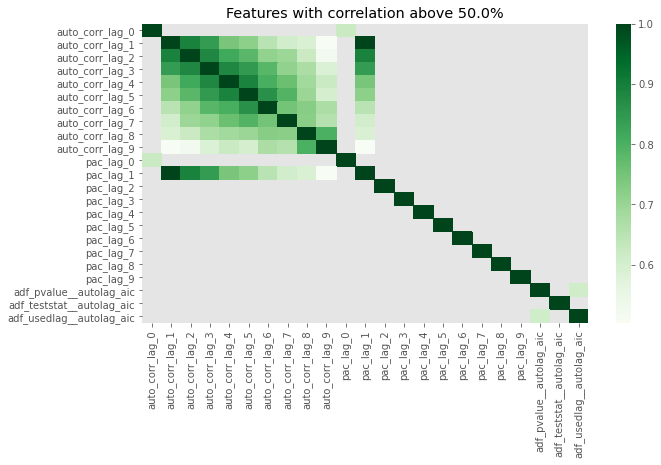

In [44]:
plot_correlated_features(stationary_features_df,0.5)

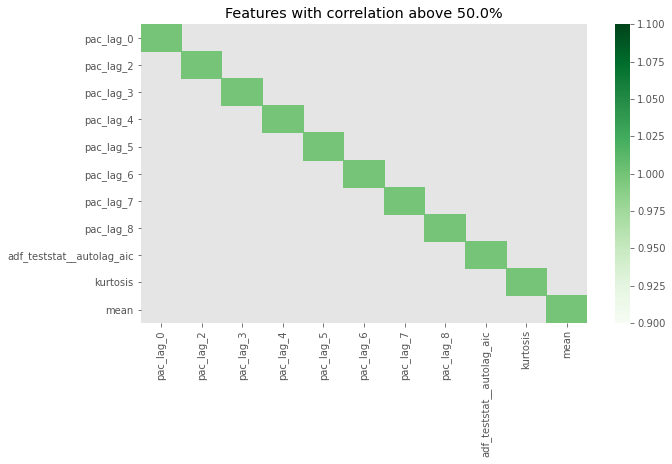

In [45]:
# Drop correlated features (threshold: 0.5)
stationarity_uncorrelated = remove_features_df(stationary_features_df,drop_correlated_pairs(stationary_features_df,0.5))
# Add statistical features to dataframe
stats_features_df = remove_outliers_iqr(features_filtered[filter_features(features_filtered,stats)])
features_uncorrelated = pd.merge(stationarity_uncorrelated,stats_features_df,on='id')
# Check if all features are not correlated
plot_correlated_features(features_uncorrelated,0.5)
plt.savefig(f"{PATH}/images/{product_name}_correlation_{experiment}")

In [46]:
#TODO: https://stats.stackexchange.com/questions/427327/simple-outlier-detection-for-time-series
# random.seed(20)
random_countries = sample(list(features_uncorrelated.index),5)
# product_excl_countries = features_uncorrelated[features_uncorrelated.index.isin(random_countries)]
# product_by_countries = features_uncorrelated[features_uncorrelated.index.isin(random_countries)]
features_uncorrelated = scale_features(features_uncorrelated)
X_scaled_transposed = np.asarray(features_uncorrelated)
print(product_name, X_scaled_transposed.shape)

non_medicinals (250, 11)


# Clustering TSFRESH extracted features

## Hierarchical clustering TS features

In [47]:
# plt.figure(figsize = (14,6))
# # plot the top five levels of the dendrogram
# linkage_matrix = plot_dendrogram(features_uncorrelated,f"{product_name}_stats_feats", p=3,color_threshold = 100,truncate_mode='level')
# plt.show()

# # # extract clusters from dendogram
# clusters = fcluster(linkage_matrix, 100, criterion='distance')
# # # create a lookup table for series in a given cluster
# features_uncorrelated_clusters = features_uncorrelated.reset_index()
# # features_uncorrelated_clusters["cluster"] = clusters
# clusts = np.unique(clusters)
# print(f'Unique clusters: {clusts}')
# features_uncorrelated_clusters.rename(columns={'id':'country'},inplace=True)
# features_uncorrelated_clustered = features_uncorrelated_clusters.set_index("cluster country".split())\
# .sort_index()


# # cluster analysis
# feats_clusters = features_uncorrelated_clusters.cluster.unique()
# for c in feats_clusters:
#   countries= features_uncorrelated_clustered.loc[c].index.get_level_values(0).unique()
#   random.seed(1)
#   n_samples = features_uncorrelated_clustered.loc[c].shape[0]
#   if n_samples > 10:
#     n = random.sample(range(n_samples),10)
#   else:
#     n = range(n_samples)
#   cluster = features_uncorrelated_clustered.loc[c].T
#   cluster.iloc[:, n].plot(subplots=True,figsize=(10,5.5),
#                           title=f"Countries in cluster_{c}_features_uncorrelated")
#   plt.xticks(rotation=70)
#   plt.legend(countries)
#   plt.savefig(f"{PATH}/images/cluster_{c}_min_feats")
#   plt.show()

## K-means clustering

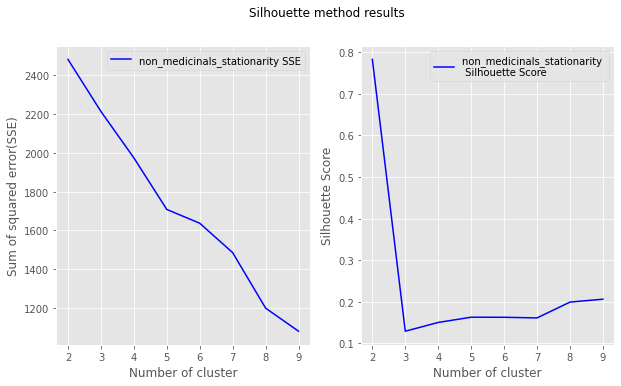

In [48]:
plot_elbow_silhoutte_k_evaluation(f"{product_name}_{experiment}",features_uncorrelated,10)  

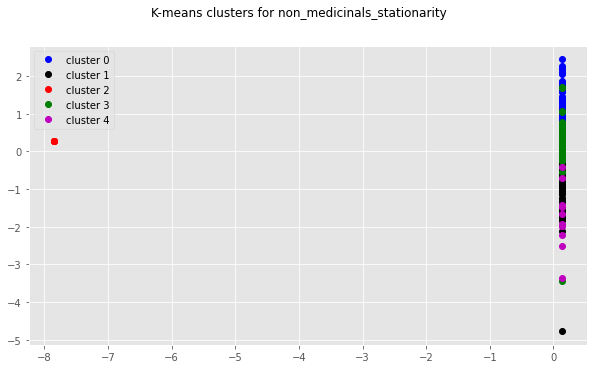

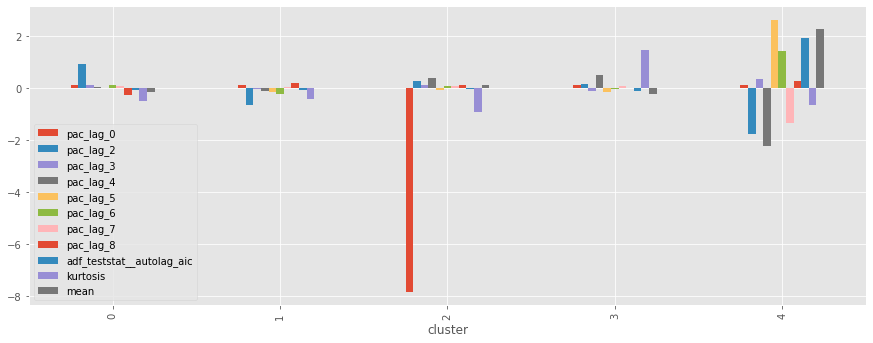

In [49]:
clusters_features_uncorrelated = plot_kmeans_clusters(
    X_scaled_transposed,5,f"{product_name}_{experiment}",f"{PATH}/images") 
#TODO: seperate def get_clusters() \\ plot_kmeans_clusters()
#TODO: function for getting names from cluster
# def get_cluster_elements()
details = [(name,cluster) for name, cluster in zip(features_uncorrelated.index,clusters_features_uncorrelated)]
cluster_df = pd.DataFrame(details,columns=['names','cluster'])
cluster_df['names'].astype('category')
get_names = features_uncorrelated.reset_index().rename(columns={'id':'names'})
get_names.names.astype('category')
country_cluster = pd.merge(get_names,cluster_df,how='inner', on='names')
# country_cluster[country_cluster.cluster==1]['names'].unique()
groups = country_cluster.groupby(['cluster']).agg('mean')
country_cluster['cluster'].unique()
#plot group features
ax = groups.plot(figsize=(15,5.5),kind='bar')
fig = ax.get_figure()
fig.savefig(f"{PATH}/images/{product_name}_{experiment}_kmeans")

## PCA + k-Means

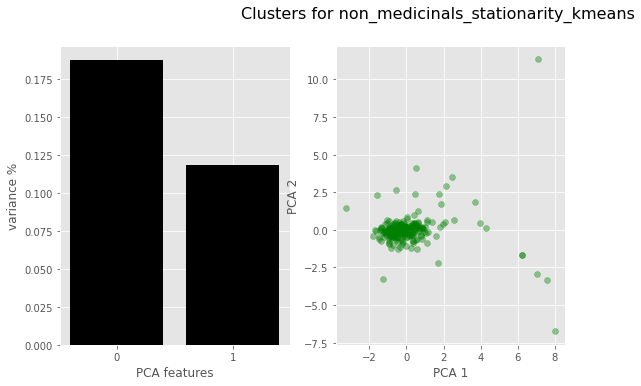

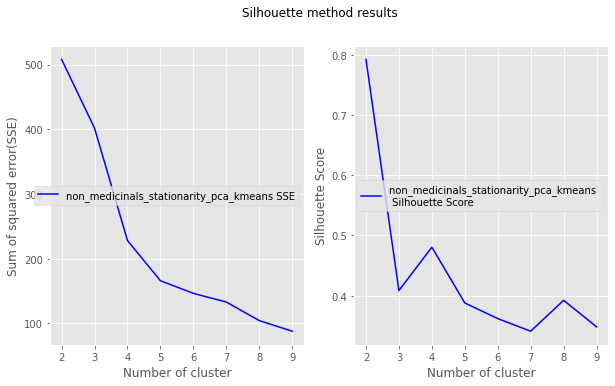

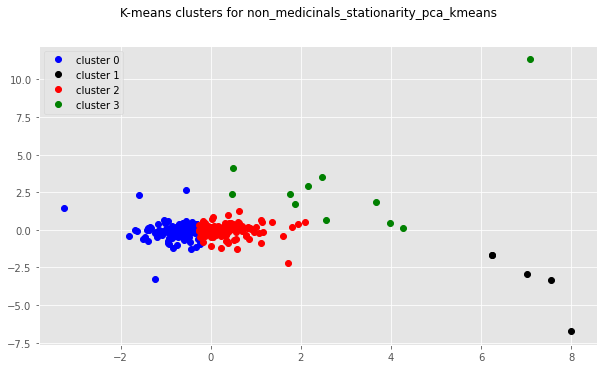

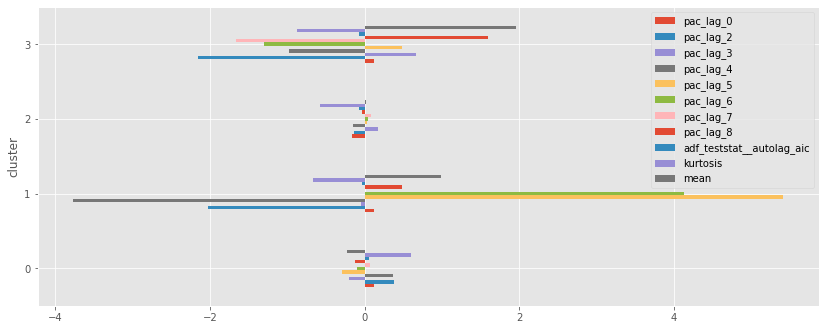

In [50]:
# Standardize the data to have a mean of ~0 and a variance of 1

# TODO: PCA plots and evaluation
# Create a PCA instance: pca
# def calculate_pca():
  # return pca_components_df

# def plot_pca_evaluation():
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features_uncorrelated)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
# Plot the explained variances
features = range(pca.n_components_)


fig = plt.figure(figsize=(14,5.5))
fig.suptitle(f"Clusters for {product_name}_{experiment}_kmeans", fontsize=16)
fig.add_subplot(131)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

fig.add_subplot(132)
plt.scatter(PCA_components[0], PCA_components[1], alpha=.4, color='green')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')


plot_elbow_silhoutte_k_evaluation(f"{product_name}_{experiment}_pca_kmeans",np.asarray(PCA_components),10)  
clusters_features_uncorrelated = plot_kmeans_clusters(np.asarray(PCA_components),4,f"{product_name}_{experiment}_pca_kmeans",f"{PATH}/images")

details = [(name,cluster) for name, cluster in zip(features_uncorrelated.index,clusters_features_uncorrelated)]
cluster_df = pd.DataFrame(details,columns=['names','cluster'])
cluster_df['names'].astype('category')
get_names = features_uncorrelated.reset_index().rename(columns={'id':'names'})
get_names.names.astype('category')
country_cluster = pd.merge(get_names,cluster_df,how='inner', on='names')
groups = country_cluster.groupby(['cluster']).agg('mean')

ax = groups.plot(figsize=(14,5.5),kind='barh')
fig = ax.get_figure()
fig.savefig(f"{PATH}/images/{product_name}_{experiment}_pca_kmeans.png")

## DBSCAN

### Hyperparameter tuning

  0%|          | 1/245 [00:00<00:27,  8.97it/s]

[dbscan] >Normalize data (unit variance, zero-mean).
[dbscan] Gridsearch on epsilon to determine optimal clusters using silhouette scores.


100%|██████████| 245/245 [00:28<00:00,  8.74it/s]

[clusteval] >Compute dendrogram threshold.
[clusteval] >Fin.


<Figure size 720x396 with 0 Axes>

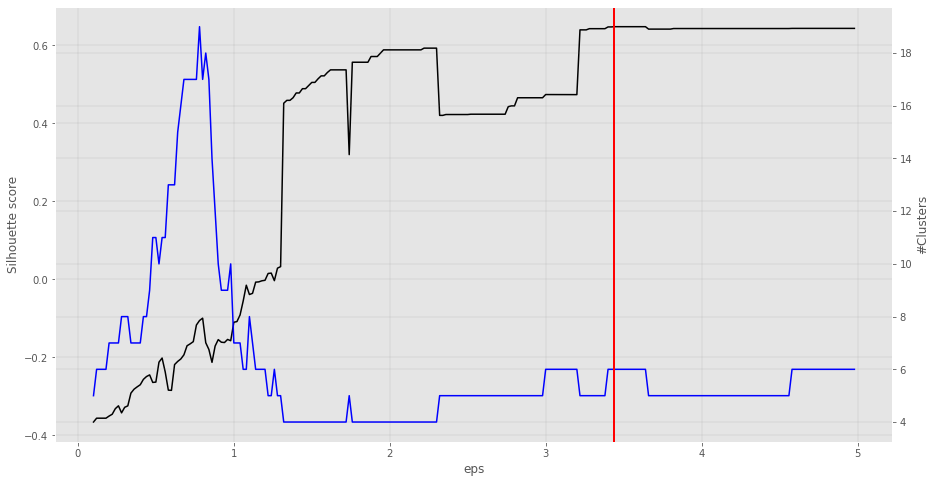

[silhouette] >Estimated number of n_clusters: 5, average silhouette_score=0.648


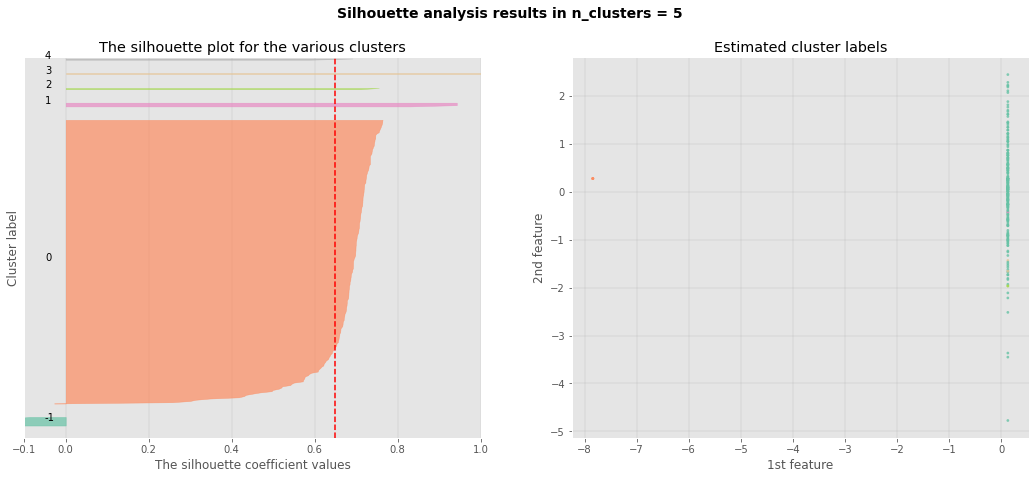

In [51]:
# https://stackoverflow.com/questions/34611038/grid-search-for-hyperparameter-evaluation-of-clustering-in-scikit-learn
!pip install -q clusteval
# Import library
from clusteval import clusteval
# Set parameters, as an example dbscan
ce = clusteval(method='dbscan')
# Fit to find optimal number of clusters using dbscan
results= ce.fit(X_scaled_transposed)
# Make plot of the cluster evaluation
plt.figure(figsize=(10,5.5))
ce.plot()
# Make scatter plot. Note that the first two coordinates are used for plotting.
ce.scatter(X_scaled_transposed)
# results is a dict with various output statistics. One of them are the labels.
cluster_labels = results['labx']

### DBSCAN clustering

[-1  0  1  2]
[-1  0  1  2]


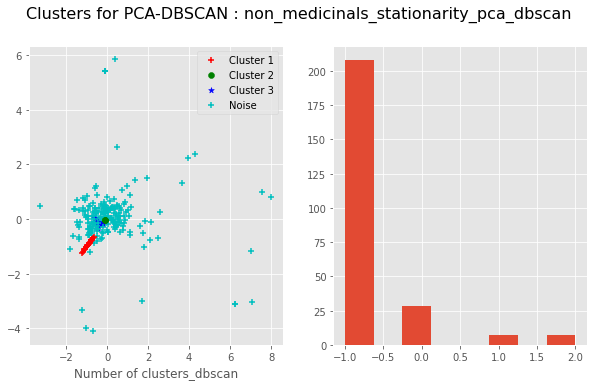

In [57]:
# https://www.dummies.com/programming/big-data/data-science/how-to-create-an-unsupervised-learning-model-with-dbscan/

dbscan = DBSCAN(eps=0.5, min_samples=5,metric='euclidean')
dbscan.fit(X_scaled_transposed)
print(np.unique(dbscan.labels_))

fig = plt.figure(figsize=(10,5.5))
fig.suptitle(f"Clusters for PCA-DBSCAN : {product_name}_{experiment}_pca_dbscan", fontsize=16)
print(np.unique(dbscan.labels_))
fig.add_subplot(121)
# fig.set_title('Clusters')
pca = PCA(n_components=4)
pca_2d = pca.fit_transform(X_scaled_transposed)
for i in range(0, pca_2d.shape[0]):
  if dbscan.labels_[i] == 0:
    c1 = plt.scatter(pca_2d[i,0],pca_2d[i,0],c='r',marker='+')
  elif dbscan.labels_[i] == 1:
    c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
  elif dbscan.labels_[i] == 2:
    c3 = plt.scatter(pca_2d[i,0],pca_2d[i,2],c='b',marker='*')
  elif dbscan.labels_[i] == 3:
    c4 = plt.scatter(pca_2d[i,0],pca_2d[i,3],c='y',marker='x')
  elif dbscan.labels_[i] == 4:
    c5 = plt.scatter(pca_2d[i,0],pca_2d[i,4],c='g',marker='*')
  elif dbscan.labels_[i] == 5:
    c6 = plt.scatter(pca_2d[i,0],pca_2d[i,5],c='r',marker='x')
  elif dbscan.labels_[i] == -1:
    cn = plt.scatter(pca_2d[i,0],pca_2d[i,-1],c='c',marker='+')
plt.xlabel("Number of clusters_dbscan")
plt.legend([c1,c2,c3,cn],['Cluster 1','Cluster 2','Cluster 3','Noise'])
# plt.legend(c,n.append['Noise'])

# plt.title('DBSCAN finds 2 clusters and noise')
fig.add_subplot(122)
# plt.set_title=("Cluster instances/frequency")
plt.hist(dbscan.labels_,bins=8)
plt.savefig(f"{PATH}/images/{product_name}_{experiment}_pca_dbscan")
plt.show()